### Preprocessing of the CAMUS dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import required libraries

In [1]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
from os import path
import random
import math
import numpy as np 
import pandas as pd 
import time
from contextlib import contextmanager # timer
from functools import partial
import seaborn as sns
#To open the .mhd files(MetaImage MetaHeader files)
import SimpleITK as sitk
import matplotlib.pylab as plt
%matplotlib inline
import cv2
from tqdm.notebook import tqdm
#Copy the files to preprocessed folder
import shutil
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 7
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

import h5py

import tensorflow as tf
from tensorflow import keras
#For data augmentation
import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from sklearn.utils import shuffle

from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from keras.models import Model, Sequential
from keras import backend as K
from unet import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.models import load_model

In [4]:
#To get the time taken for processing
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

In [5]:
Image_Size = 384

In [6]:
ROOT_PATH='/content/drive/MyDrive/Medical_Imaging/LVEF/Datasets/CAMUS/Original/database/Preprocessed/'
TRAIN_PATH=ROOT_PATH+'training/'
TEST_PATH=ROOT_PATH+'testing/'
MODEL_PATH = ROOT_PATH+"model.h5"
CSV_PATH = ROOT_PATH+"log.csv"

In [7]:
# Z Normalize image by subtracting the mean and dividing by the standrad deviation
def data_norm(input):
    input = np.array(input, dtype=np.float32)
    input  = input - np.mean(input)
    #Add a very small value in denominator to prevent zero division
    output = input / (np.std(input) + 1e-12)
    return output

In [8]:
#Read the .mhd files as array
def mhd_to_array(path):
    """
    Read a *.mhd file stored in path and return it as a numpy array.
    """
    return sitk.GetArrayFromImage(sitk.ReadImage(path, sitk.sitkFloat32))

In [9]:
#Read the .cfg file and return data as a dictionary
def read_info(data_file):
  info = {}
  with open( data_file, 'r' ) as f:
    for line in f.readlines():
      info_type, info_details = line.strip( '\n' ).split( ': ' )
      info[ info_type ] = info_details
  return info

## Load images with augmentation from the files

In [10]:
#Read image and mask from the above file
f = h5py.File(ROOT_PATH+"image_dataset.hdf5", "r")
train_frames = f["train 4ch frames"]
print(train_frames.shape)
train_masks = f["train 4ch masks"]
print(train_masks.shape)

(900, 384, 384, 1)
(900, 384, 384, 1)


In [11]:
test_frames = f["test 4ch frames"]
print(test_frames.shape)
test_masks = f["test 4ch masks"]
print(test_masks.shape)

(100, 384, 384, 1)
(100, 384, 384, 1)


In [12]:
class LoadDataset(keras.utils.Sequence):
    def __init__(self, c_type,trainortest, augment_params,batch_size=8,img_size=(Image_Size,Image_Size)):
        self.all_frames = self.extract_files(c_type,trainortest,False)
        self.all_masks = self.extract_files(c_type,trainortest,True)
        self.augment_params = augment_params
        self.batch_size = batch_size
        self.img_size = img_size
    
    @staticmethod
    def extract_files(c_type,trainortest,ismask):
        """
        Extract the paths to all slices given the root path (ends with train or val)
        """
        files = []
        if c_type=='4C':
          path=trainortest+" 4ch frames"
          if ismask:
            path=trainortest+" 4ch masks"
        else:
          path=trainortest+" 2ch frames"
          if ismask:
            path=trainortest+" 2ch masks"
        for file in f[path]:  
          files.append(file)
        return files


    def augment(self, frame, mask):
      seed=random.randint(0,100)
      imgaug.seed(seed)
      mask = SegmentationMapsOnImage(mask, mask.shape)
      frame_aug, mask_aug = self.augment_params(image=frame, segmentation_maps=mask)
      mask_aug = mask_aug.get_arr()
      return frame_aug, mask_aug
    
    def __len__(self):
        """
        Return the length of the dataset (length of all files)
        """
        return math.ceil(len(self.all_masks) / self.batch_size)
    
    
    def __getitem__(self, idx):
        """
        Given an index return the (augmented) frame and corresponding mask
        """

        i = idx * self.batch_size
        frames = self.all_frames[i : i + self.batch_size]
        masks = self.all_masks[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size +(1,) , dtype="float32")
        for j, frame in enumerate(frames):
          x[j] = frame
        
        y = np.zeros((self.batch_size,) + self.img_size+(1,) , dtype="int32")
        for j, mask in enumerate(masks):
          y[j] = mask

        for j in range(self.batch_size):
          if self.augment_params:
            x[j], y[j] = self.augment(x[j], y[j])
        return x,y
        #return np.expand_dims(slice, 0), np.expand_dims(mask, 0)

    def on_epoch_end(self):
        seed=random.randint(0,100)
        self.all_frames=shuffle(self.all_frames,random_state=seed)
        self.all_masks=shuffle(self.all_masks,random_state=seed)
 

In [13]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15), # zoom in or out
               rotate=(-45, 45)),  # rotate up to 45 degrees
    iaa.ElasticTransformation()
                ])

In [14]:
# Create the dataset object for frames/masks with augmentation for training
train_4C_generator = LoadDataset('4C','train', seq)
#train_2C_generator = LoadDataset('2C','train', seq)

In [15]:
# Create the dataset object for frames/masks without augmentation for validation
test_4C_generator = LoadDataset('4C','test' ,None)
#test_2C_generator = LoadDataset('2C','test' None)

In [16]:
train_4C_generator

In [17]:
frames, masks = train_4C_generator[0]
frames.shape,masks.shape

((8, 384, 384, 1), (8, 384, 384, 1))

In [18]:
len(train_4C_generator),len(test_4C_generator)

(113, 13)

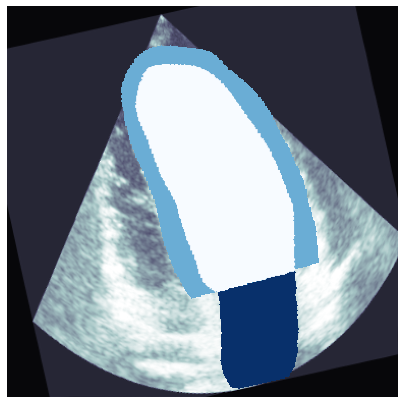

In [19]:
#Sample visualisation
frame, mask = frames[0],masks[0]
mask_ = np.ma.masked_where(mask==0, mask)
plt.imshow(frame, cmap="bone")
plt.imshow(mask_, cmap="Blues")
plt.axis("off")
plt.show()

### U-Net Model Training

In [20]:
model = unet()
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 384, 384, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 384, 384, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

In [21]:
def dice_coefficients(y_true, y_pred, epsilon=1e-6): 
    y_true=tf.cast(y_true, tf.float32)
    y_pred=tf.cast(y_pred, tf.float32)
    # skip the batch and class axis for calculating Dice score
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * K.sum(y_pred * y_true, axes)
    denominator = K.sum(K.square(y_pred) + K.square(y_true), axes)
    
    return K.mean((numerator + epsilon) / (denominator + epsilon)) # average over classes and batch



# def dice_coefficients(y_true, y_pred):
#     y_true=tf.cast(y_true, tf.float32)
#     y_pred=tf.cast(y_pred, tf.float32)
#     smooth=100
#     smooth = tf.cast(smooth, y_pred.dtype)
#     y_true_flatten = K.flatten(y_true)
#     y_pred_flatten = K.flatten(y_pred)

#     intersection = K.sum(y_true_flatten * y_pred_flatten)
#     union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
#     return (2 * intersection + smooth) / (union + smooth)


def dice_loss(y_true, y_pred):
    return 1-dice_coefficients(y_true, y_pred)

# def iou(y_true, y_pred, smooth=100):
#     intersection = K.sum(y_true * y_pred)
#     sum = K.sum(y_true + y_pred)
#     iou = (intersection + smooth) / (sum - intersection + smooth)
#     return iou


# smooth = 1e-15
# def dice_coef(y_true, y_pred):
#     y_true=tf.cast(y_true, tf.float32)
#     y_pred=tf.cast(y_pred, tf.float32)
#     y_true = tf.keras.layers.Flatten()(y_true)
#     y_pred = tf.keras.layers.Flatten()(y_pred)
#     intersection = tf.reduce_sum(y_true * y_pred)
#     return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# def dice_loss(y_true, y_pred):
#     return 1.0 - dice_coef(y_true, y_pred)


# def iou(y_true, y_pred):
#     intersection = K.sum(y_true * y_pred)
#     sum = K.sum(y_true + y_pred)
#     iou = (intersection + smooth) / (sum - intersection + smooth)
#     return iou



In [22]:
EPOCHS = 20
BATCH_SIZE = 8
learning_rate = 1e-4
smooth=100

In [23]:
opt = Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=dice_loss, metrics=[dice_coefficients])
#callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)]
callbacks = [ModelCheckpoint(MODEL_PATH, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(CSV_PATH),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

In [ ]:
# history = model.fit(x=train_4C_generator,epochs=EPOCHS, 
#                     callbacks=callbacks,validation_data = test_4C_generator)


In [26]:
model=load_model(MODEL_PATH,compile=False)

In [28]:
model.compile(optimizer=opt, loss=dice_loss, metrics=[dice_coefficients])
history = model.fit(x=train_4C_generator,epochs=EPOCHS, 
                    callbacks=callbacks,validation_data = test_4C_generator)

Epoch 1/20
113/113 [==============================] - ETA: 0s - loss: 0.2974 - dice_coefficients: 0.7026
Epoch 1: val_loss improved from inf to 0.33237, saving model to /content/drive/MyDrive/Medical_Imaging/LVEF/Datasets/CAMUS/Original/database/Preprocessed/model.h5
113/113 [==============================] - 169s 1s/step - loss: 0.2974 - dice_coefficients: 0.7026 - val_loss: 0.3324 - val_dice_coefficients: 0.6676 - lr: 1.0000e-04
Epoch 2/20
113/113 [==============================] - ETA: 0s - loss: 0.2952 - dice_coefficients: 0.7048
Epoch 2: val_loss improved from 0.33237 to 0.32743, saving model to /content/drive/MyDrive/Medical_Imaging/LVEF/Datasets/CAMUS/Original/database/Preprocessed/model.h5
113/113 [==============================] - 133s 1s/step - loss: 0.2952 - dice_coefficients: 0.7048 - val_loss: 0.3274 - val_dice_coefficients: 0.6726 - lr: 1.0000e-04
Epoch 3/20
113/113 [==============================] - ETA: 0s - loss: 0.2947 - dice_coefficients: 0.7053
Epoch 3: val_loss imp

In [ ]:
#Trained for 40 epochs currently with 4C ED and ES images with masks